<a href="https://colab.research.google.com/github/FernandoIGD12/UTEC_programming101/blob/main/Intro_AI/proyecto_final_v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
# Import the necessary libraries and function
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# download the urbania dataset with property listing from all over Peru
!gdown --id 1d_M8c0wP8ID0jlq8WjTKAcCk2EsiX-ys

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1d_M8c0wP8ID0jlq8WjTKAcCk2EsiX-ys
From (redirected): https://drive.google.com/uc?id=1d_M8c0wP8ID0jlq8WjTKAcCk2EsiX-ys&confirm=t&uuid=a691795f-fc0c-4006-90f6-3a34c8efa377
To: /content/urbania_2025-06-19.csv
100% 110M/110M [00:01<00:00, 74.4MB/s]


In [16]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('urbania_2025-06-19.csv', encoding = 'latin')
df.replace('NaN', np.nan, inplace = True)
df.head()

,website,code,property_type,property_subtype,operation_type,region_lv1,region_lv2,region_lv3,name,address,...,clinic_hospital_num,atm_num,bus_station_num,subway_station_num,marketplace_num,university_num,library_num,img_urls,description,attributes
0,Urbania,59971409,HOUSE,Casa,FOR_SALE,Lima,Lima,La Molina,Oportunidad por viaje en RincÃ³n de la Planicie,"RINCON DE LA PLANICIE, La Planicie, La Molina,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/59/9...,ANTES: $ 549 000 AHORA: $ 499 000 CÃDIGO: CV....,Areas de BBQ () | Ãreas de lavanderÃ­a () | J...
1,Urbania,62177554,APARTMENT,Departamento,FOR_SALE,Lima,Lima,San Isidro,DE LUJO CON JARDÃN! DEPARTAMENTO EN VENTA ZON...,"Calle Chabrier, San Isidro, Lima, Lima",...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/62/1...,Una joya!!! Es un DEPA-CASA en Exclusivo Edifi...,Ascensores (1) | JardÃ­nes () | Patios () | Te...
2,Urbania,60534780,APARTMENT,Departamento,FOR_SALE,Lima,Lima,Santiago de Surco,OCASION!! VENDO DEPARTAMENTO FULL EQUIPADO EDI...,Av CircunvalaciÃ³n del Golf 148 - PRECIO DE OC...,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/60/5...,VENDO DEPARTAMENTO EN EL EDIFICIO MOON GOLF LO...,Areas de BBQ () | Ãreas de lavanderÃ­a () | A...
3,Urbania,62550452,HOUSE,Casa,FOR_SALE,Lima,Lima,Santiago de Surco,EXCLUSIVA RESIDENCIA - JR TOMASAL - SURCO,"JR TOMASAL 489 SANTIAGO DE SURCO, San Jorge, S...",...,2.0,NaN,NaN,1.0,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/62/5...,EXCLUSIVA Y ACOGEDORA RESIDENCIA EN CALLE TOMA...,Areas de BBQ () | Ãreas de lavanderÃ­a () | J...
4,Urbania,62699953,APARTMENT,Departamento,FOR_SALE,Lima,Lima,Miraflores,VENTA DEPARTAMENTO VISTA AL MAR MIRAFLORES DUPLEX,"Av. MalecÃ³n Cisneros 1100, Malecon Reserva, M...",...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/62/6...,Venta de DÃºplex de lujo finos acabados. estr...,Areas de BBQ () | Ãreas de lavanderÃ­a () | A...


In [17]:
df.groupby(['property_type', 'property_subtype'], as_index = False)['code'].count()

,property_type,property_subtype,code
0,APARTMENT,Departamento,24257
1,APARTMENT,Proyecto de lotes,3
2,APARTMENT,Proyecto horizontal-vertical,19
3,APARTMENT,Proyecto vertical,48
4,COMMERCIAL,Local Comercial,3543
5,COMMERCIAL,Local Industrial,942
6,HOUSE,Casa,7635
7,HOUSE,Casa de campo,259
8,HOUSE,Casa de playa,661
9,HOUSE,Condominio de casas,2


After a preliminary inspection of the features, we note that some of them do not contribute at all to the task at hand so we delete them. For the case of price, we keep only the price in USD, as the local currency price ('price') is subject to changes in the exchange rate. Then, we filter only listings from the Lima metropolitan area and those that are on sale and not for rent.

In [18]:
# Drop the irrelevant columns
df.drop(['website', 'code', 'name', 'address', 'lat', 'lng', 'constructed_area_unit', 'total_area_unit', 'price', 'local_currency', 'exchange_rate',
         'fetched_price_currency', 'contact_name', 'contact_email', 'contact_phone','date_inserted', 'last_edited', 'date_published', 'url', 'img_urls',
         'description', 'attributes'] ,axis = 1, inplace = True)

# Filter the desired regions and sale listings
df = df[(df['region_lv1'] == 'Lima') & (df['region_lv2'] == 'Lima') & (df['operation_type'] == 'FOR_SALE') & ((df['property_type'] == 'HOUSE') |
       ((df['property_type'] == 'APARTMENT') & (df['property_subtype'] == 'Departamento')))  & (df['posting_type'] == 'PROPERTY')]

df.drop(['region_lv1', 'region_lv2', 'operation_type', 'posting_type', 'property_type'], axis = 1, inplace = True)

/tmp/ipython-input-18-3718426133.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['region_lv1', 'region_lv2', 'operation_type', 'posting_type', 'property_type'], axis = 1, inplace = True)


In [19]:
print(df.shape)
df.isnull().sum().sort_values(ascending = False)

(23916, 34)


,0
university_num,23520
subway_station_num,23181
elevator_num,22892
library_num,22712
marketplace_num,22003
fuel_station_num,21568
building_floors,21531
bus_station_num,20525
floor_num,19291
atm_num,17508


In [30]:
# Features to deltee because of too many missing values
to_delete = ['university_num', 'subway_station_num', 'elevator_num', 'library_num', 'marketplace_num', 'fuel_station_num', 'building_floors', 'bus_station_num',
             'floor_num', 'atm_num', 'place_of_worship_num', 'clinic_hospital_num', 'bank_num', 'cafe_bar_num', 'pharmacy_num', 'school_num', 'restaurant_num',
             'kindergarten_num']

#to_delete = ['elevator_num', 'building_floors', 'floor_num']
df_clean = df.drop(to_delete, axis = 1)

# Features to replace with zeros
to_replace_zeros = ['constructed_area', 'bedrooms_num', 'bathrooms_num', 'garage_num', 'price_per_constructed_sq_m_usd', 'constructed_sq_m_region_diff_pc']
#to_replace_zeros = ['constructed_area', 'bedrooms_num', 'bathrooms_num', 'garage_num', 'price_per_constructed_sq_m_usd', 'constructed_sq_m_region_diff_pc',
#                   'university_num', 'subway_station_num', 'library_num', 'marketplace_num', 'fuel_station_num', 'bus_station_num', 'atm_num', 'place_of_worship_num',
#                    'clinic_hospital_num', 'bank_num', 'cafe_bar_num', 'pharmacy_num', 'school_num', 'restaurant_num', 'kindergarten_num']
df_clean[to_replace_zeros] = df_clean[to_replace_zeros].fillna(0)

# Samples to delete because relevant data is missing
df_clean.dropna(subset=['total_area', 'region_lv3'], inplace=True)


In [31]:
print(df.shape)
df_clean.isnull().sum().sort_values(ascending = False)

(23916, 34)


,0
property_subtype,0
region_lv3,0
constructed_area,0
total_area,0
bedrooms_num,0
bathrooms_num,0
garage_num,0
price_usd,0
price_per_constructed_sq_m_usd,0
price_per_total_sq_m_usd,0


In [32]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23902 entries, 0 to 47183
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   property_subtype                    23902 non-null  object 
 1   region_lv3                          23902 non-null  object 
 2   constructed_area                    23902 non-null  float64
 3   total_area                          23902 non-null  float64
 4   bedrooms_num                        23902 non-null  float64
 5   bathrooms_num                       23902 non-null  float64
 6   garage_num                          23902 non-null  float64
 7   price_usd                           23902 non-null  float64
 8   price_per_constructed_sq_m_usd      23902 non-null  float64
 9   price_per_total_sq_m_usd            23902 non-null  float64
 10  avg_price_per_constructed_sq_m_usd  23902 non-null  float64
 11  avg_price_per_total_sq_m_usd        23902 non-

In [33]:
#property_type_dummies = pd.get_dummies(df['property_type'])
property_subtype_dummies = pd.get_dummies(df_clean['property_subtype'])
region_dummies = pd.get_dummies(df_clean['region_lv3'])
condition_dummies = pd.get_dummies(df_clean['condition'], drop_first = True)

df_clean = pd.concat([df_clean, property_subtype_dummies, region_dummies, condition_dummies], axis=1)
df_clean.drop(['property_subtype', 'region_lv3', 'condition'], axis=1, inplace=True)
print(df_clean.shape)
df_clean.head()

(23902, 61)


,constructed_area,total_area,bedrooms_num,bathrooms_num,garage_num,price_usd,price_per_constructed_sq_m_usd,price_per_total_sq_m_usd,avg_price_per_constructed_sq_m_usd,avg_price_per_total_sq_m_usd,...,San MartÃ­n de Porres,San Miguel,Santa Anita,Santa MarÃ­a del Mar,Santa Rosa,Santiago de Surco,Surquillo,Villa El Salvador,Villa MarÃ­a del Triunfo,USED
0,360.0,430.0,4.0,4.0,3.0,499000.0,1386.0,1160.0,1872.0,1472.0,...,False,False,False,False,False,False,False,False,False,False
1,455.0,575.0,3.0,3.0,3.0,2350000.0,5165.0,4087.0,2586.0,2487.0,...,False,False,False,False,False,False,False,False,False,True
2,150.0,176.0,3.0,3.0,2.0,338000.0,2253.0,1920.0,1833.0,1740.0,...,False,False,False,False,False,True,False,False,False,True
3,410.0,475.0,4.0,3.0,2.0,890000.0,2171.0,1874.0,1833.0,1740.0,...,False,False,False,False,False,True,False,False,False,True
4,307.0,307.0,3.0,3.0,2.0,1199500.0,3907.0,3907.0,2337.0,2249.0,...,False,False,False,False,False,False,False,False,False,False


In [89]:
X = df_clean.drop('price_usd', axis=1)
y = df_clean['price_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
Input_rf = [('Scaler', StandardScaler()), ('model',RandomForestRegressor(random_state=42))]
pipe_rf = Pipeline(Input_rf)
param_grid = {
    'model__n_estimators': [80, 100, 150],       # Number of trees
    #'model__max_features': [1.0, 'sqrt', 'log2'],  # Features considered for splits

}

grid_rf = GridSearchCV(estimator = pipe_rf, param_grid = param_grid, cv = 5, scoring = 'r2', n_jobs = -1)
grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_)
print(grid_rf.score(X_train, y_train))
print(grid_rf.score(X_test, y_test))



{'model__n_estimators': 150}
0.8476954301231838
0.8633495151948123


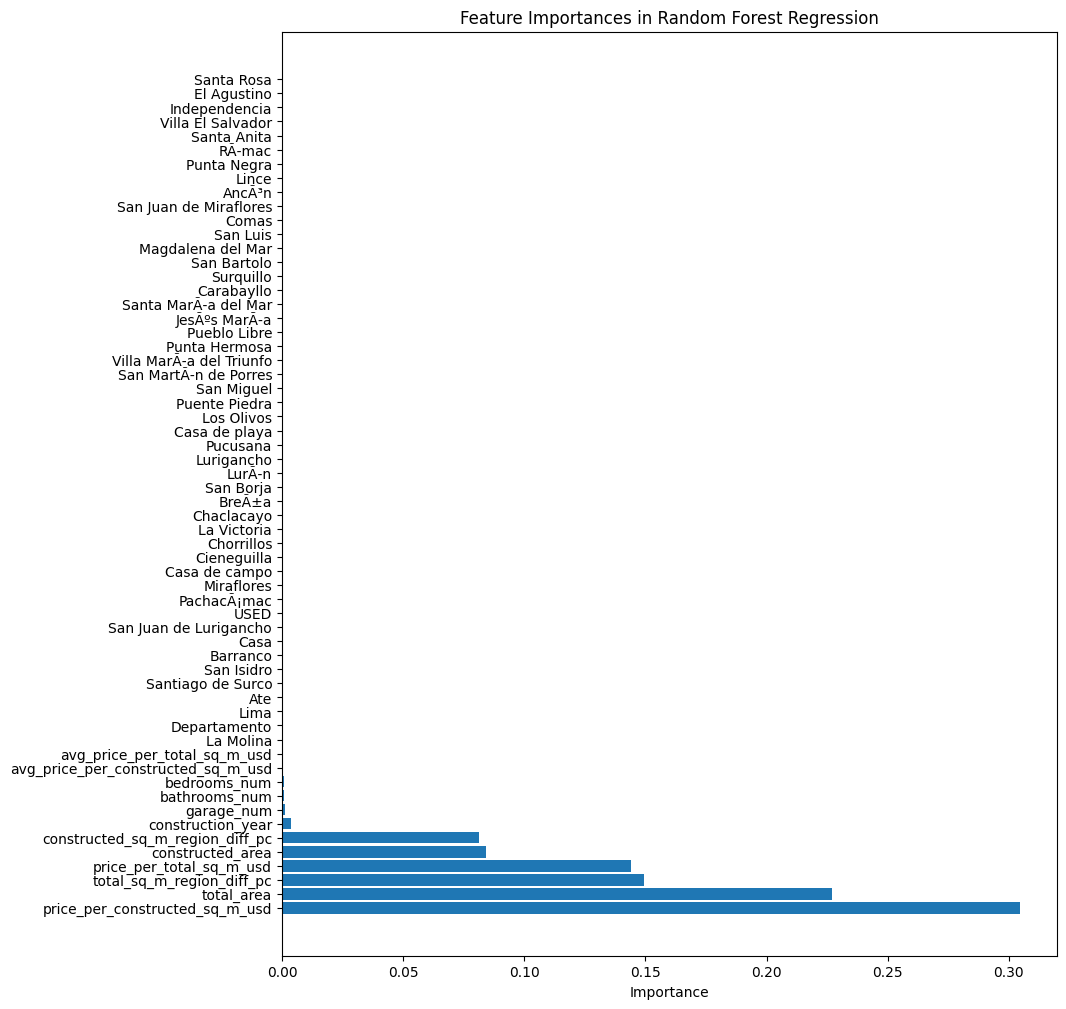

In [93]:
importances = grid_rf.best_estimator_.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1] # Sort in ascending order
features = X.columns

# Plot feature importances
figure = plt.figure(figsize=(10, 12))
plt.barh(range(X.shape[1]), importances[indices],  align="center")
plt.yticks(range(X.shape[1]), [features[i] for i in indices])
plt.xlabel("Importance")
plt.title("Feature Importances in Random Forest Regression")
plt.show()

In [72]:
Input_gb = [('Scaler', StandardScaler()), ('model', GradientBoostingRegressor(random_state=42))]
pipe_gb = Pipeline(Input_gb)
param_grid = {
    'model__n_estimators': [80, 100, 150],
    'model__learning_rate': [0.01]
}

grid_gb = GridSearchCV(estimator = pipe_gb, param_grid = param_grid, cv = 5, scoring = 'r2', n_jobs = -1)
grid_gb.fit(X_train, y_train)

print(grid_gb.best_params_)
print(grid_gb.score(X_train, y_train))
print(grid_gb.score(X_test, y_test))

{'model__learning_rate': 0.01, 'model__n_estimators': 80}
0.7579354025198717
0.8164661438940813


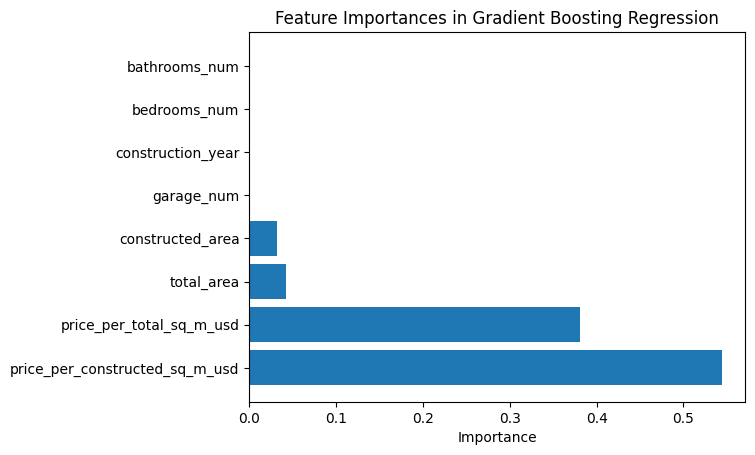

In [88]:
importances = grid_gb.best_estimator_.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1] # Sort in descending order
features = X.columns

# Plot feature importances
plt.barh(range(X.shape[1]), importances[indices],  align="center")
plt.yticks(range(X.shape[1]), [features[i] for i in indices])
plt.xlabel("Importance")
plt.title("Feature Importances in Gradient Boosting Regression")
plt.show()

In [96]:
selected_features = ['price_usd',  'price_per_constructed_sq_m_usd', 'total_area', 'total_sq_m_region_diff_pc',
                    'price_per_total_sq_m_usd', 'constructed_area', 'constructed_sq_m_region_diff_pc','construction_year']
df_final = df_clean[selected_features].copy()
X = df_final.drop('price_usd', axis=1)
y = df_final['price_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
pipe_rf_pc = Pipeline([('Scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=42, n_estimators=150))])
pipe_rf_pc.fit(X_train, y_train)
print(pipe_rf_pc.score(X_train, y_train))
print(pipe_rf_pc.score(X_test, y_test))

0.8459693479880087
0.8642760290435798


<Axes: >

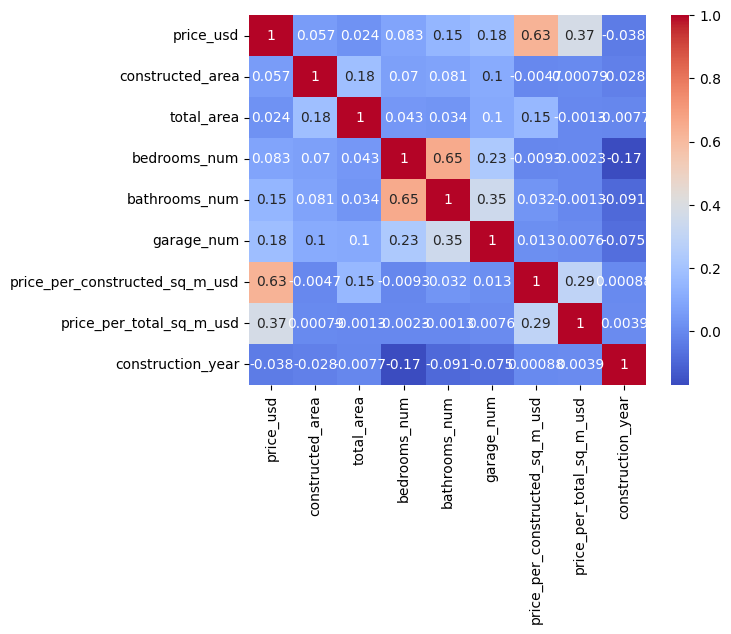

In [ ]:
sns.heatmap(df_final.corr(), annot = True, cmap = 'coolwarm')